# ATTENTION

Ce notebook a été créé en attendant que l'application evofond intègre la possibilité d'injecter des débits au milieu d'un profil. Si vous êtes ici, c'est pour utiliser un prototype de cette fonctionnalité ***qui n'a pas été validé***. Soyez donc très vigilant aux résultats que vous pourrez observer. Par ailleurs, veillez à ne pas modifier le fichier original mais bien une copie afin que n'importe qui puisse réutiliser ce prototype en l'état. N'oubliez pas d'éxécuter toutes les cellules !

N'hésitez pas à envoyer vos remarques ou questions à l'adresse *clement.roussel@onf.fr*

In [1]:
from back.sedimentTransport.lefort2015 import Lefort2015
from back.sedimentTransport.lefortsogreah1991 import LefortSogreah1991
from back.sedimentTransport.meunier1989 import Meunier1989
from back.sedimentTransport.meyerpeter1948 import MeyerPeter1948
from back.sedimentTransport.piton2016 import Piton2016
from back.sedimentTransport.rickenmann1990 import Rickenmann1990
from back.sedimentTransport.rickenmann1991 import Rickenmann1991
from back.profileForInjection import Profile
from back.rectangularSection import RectangularSection
from back.granulometry import Granulometry
from back.utils import calcSedimentogram

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Définition des fonctions utilisées

In [3]:
def importRectangularProfile(path, granulometry, manning=None, name='Profile', interpolation=False, dx=None):
    """
    Take the path of a .csv file wich much contains the following columns named as written between quotes ('') :
    - 'x' (abscissa [m])
    - 'z' (bottom depth [m])
    - 'z_min' (minimal bottom depth [m])
    - 'b' (width [m])
    """
    df = pd.read_csv(path)
    for col in ['x', 'z', 'z_min', 'b']:
        if col not in df.columns:
            raise ValueError("You csv file must contain the following columns : x, z, z_min, b")
        df = df[~(df[col].isnull())] # eliminating None values
        
    sectionList = []
    xMaxi = max(list(df['x']))
    xMini = min(list(df['x']))
    for i in range(df['x'].size):
        sectionList.append(RectangularSection(xMini + xMaxi - df['x'][i], df['z'][i], df['b'][i], z_min=df['z_min'][i], granulometry=granulometry, manning=manning))
        
    profile = Profile(sectionList, name=name)
    if interpolation and dx != None:
        profile.complete(dx)
    return profile

def importHydrogram(path):
    """
    Take the path of a .csv file wich much contains the following columns named as written between quotes ('') :
    - 't' (time [s]) /!\ unit : seconds not hours
    - 'Q' (water discharge [m3/s]) /!\ uppercase
    """
    df = pd.read_csv(path)
    for col in ['t', 'Q']:
        if col not in df.columns:
            raise ValueError("You csv file must contain the following columns : t, Q")
        df = df[~(df[col].isnull())] # eliminating None values
        
    return (df['t'], df['Q'])
        

## Création du profil

In [4]:
# Paramètres de création du profil : à modifier à votre guise

path_profile = "C:\\Users\\Bacon\\OneDrive\\Bureau\\RTM\\pyqt_tuto\\evofond_v2\\test.csv"

granulometry = Granulometry(dm=0.041, d30=0.0229, d50=0.034, d90=0.034, d84tb=0.063, d84bs=0.063, Gr=2) # Give all parameters

manning = None # Can be set on None, a manning coefficient can be computed using granulometry

name = "Profile" # If you want to give a pretty name !

interpolation = True

dx = 10 # Not important if interpolation is set on False

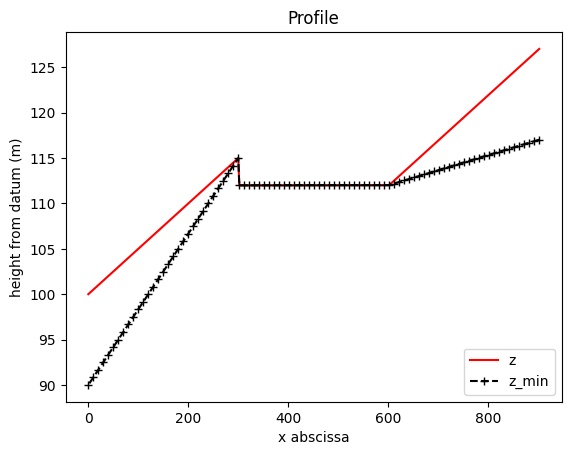

In [5]:
profile = importRectangularProfile(path_profile, granulometry, manning=manning, name=name, interpolation=interpolation, dx=dx)
fig = profile.plot()

## Hydrogramme amont

In [6]:
path_hydro = "C:\\Users\\Bacon\\OneDrive\\Bureau\\RTM\\pyqt_tuto\\evofond_v2\\test1.csv"

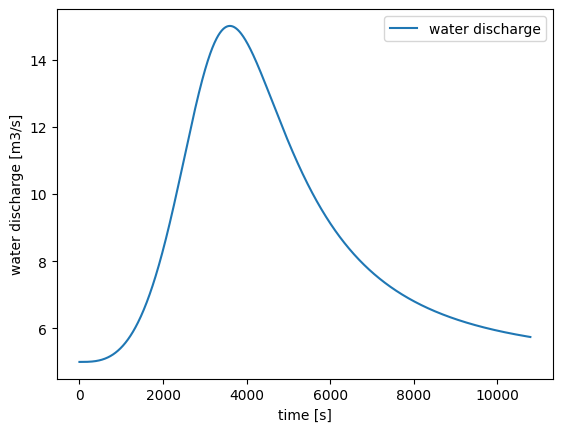

In [7]:
t, Q = importHydrogram(path_hydro)

plt.plot(t, Q, label="water discharge")
plt.xlabel("time [s]")
plt.ylabel("water discharge [m3/s]")
plt.legend()
plt.show()

## Hydrogramme injecté

In [8]:
path_injected_hydro = "C:\\Users\\Bacon\\OneDrive\\Bureau\\RTM\\pyqt_tuto\\evofond_v2\\test2.csv"

x_injection = 650 

In [10]:
if x_injection < min(profile.get_x_list()) or x_injection > max(profile.get_x_list()):
    raise ValueError(f"the abscissa must be between {min(profile.get_x_list())} and {max(profile.get_x_list())}")

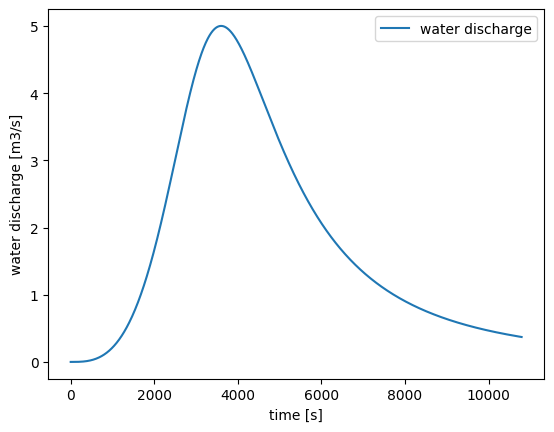

In [11]:
t_injected, Q_injected = importHydrogram(path_injected_hydro)

plt.plot(t_injected, Q_injected, label="water discharge")
plt.xlabel("time [s]")
plt.ylabel("water discharge [m3/s]")
plt.legend()
plt.show()

## Sédimentogramme amont

In [12]:
# Choose your transport law by commenting the other ones

sedimentTransportLaw = Lefort2015()
# sedimentTransportLaw = LefortSogreah1991()
# sedimentTransportLaw = Meunier1989()
# sedimentTransportLaw = MeyerPeter1948()
# sedimentTransportLaw = Piton2016()
# sedimentTransportLaw = Rickenmann1990()
# sedimentTransportLaw = Rickenmann1991()

width = 8 # [m]

slope = 0.1 # [m/m]

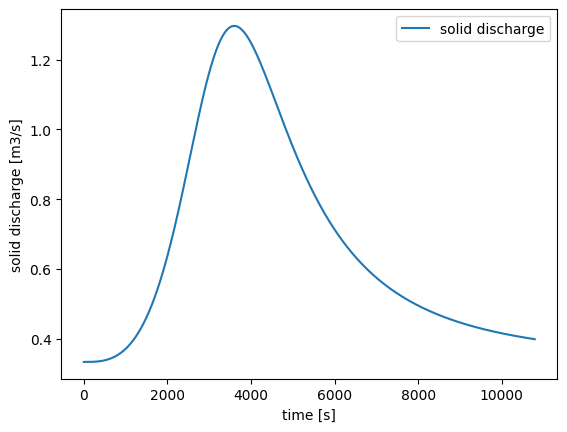

In [13]:
Qs = calcSedimentogram(sedimentTransportLaw, Q, width, slope, granulometry)

plt.plot(t, Qs, label="solid discharge")
plt.xlabel("time [s]")
plt.ylabel("solid discharge [m3/s]")
plt.legend()
plt.show()

## Modèle

In [14]:
critical = True # booleen (True ou False)

friction_law = "Ferguson" # 'Ferguson' or 'Manning-Strickler'

upstream_condition = "critical_depth"

downstream_condition = "critical_depth"

cfl = 1

dt = None

dt_save = 60 # [s]

## Calcul du résultat

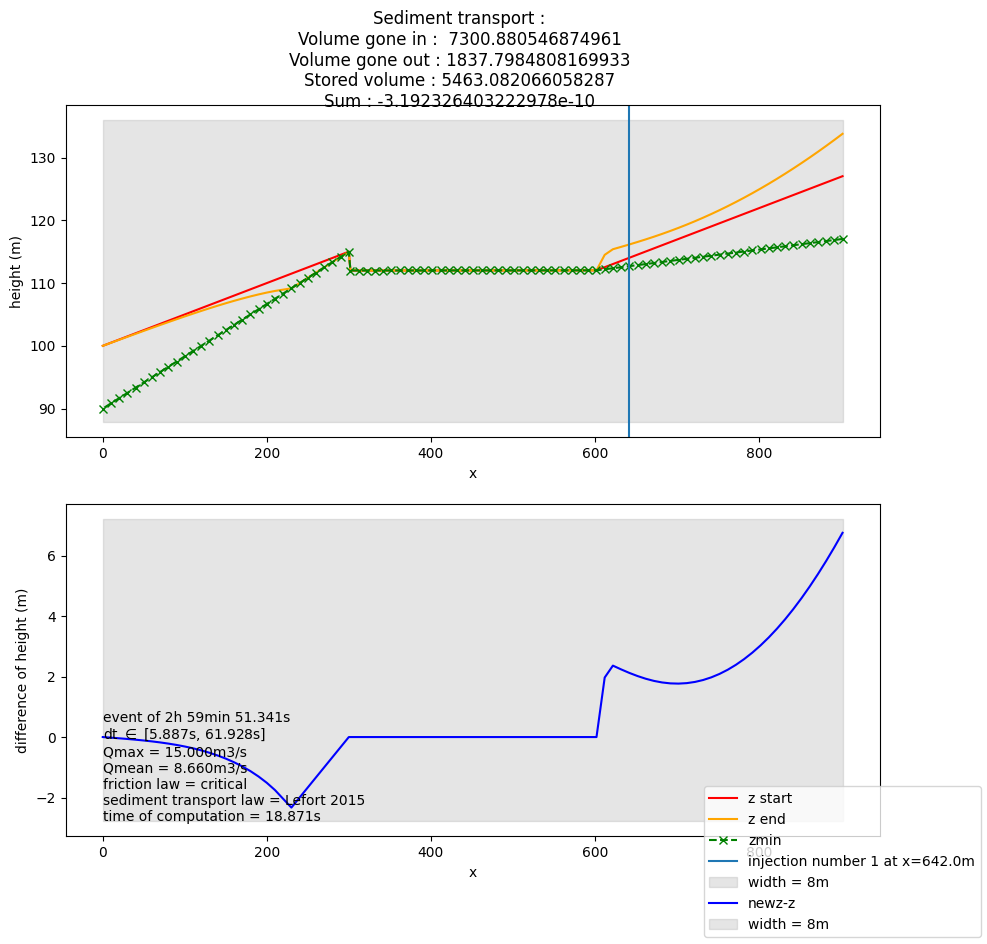

In [15]:
# Lancez l'exécution de cette cellule, cela peut prendre quelques minutes. Soyez patients

profile_copy = profile.copy()

result = profile_copy.compute_event(
    hydrogram = Q, 
    t_hydrogram = list(t), 
    law = sedimentTransportLaw, 
    sedimentogram = Qs,
    friction_law = friction_law, 
    cfl = cfl, 
    dt = dt, 
    dt_save = dt_save, 
    critical = critical, 
    upstream_condition = upstream_condition, 
    downstream_condition = downstream_condition, 
    plot=True, 
    injection_list=[(x_injection, t_injected, Q_injected)]
)

plt.show()